
## Processing Sensor Data from Catalina Jemez CZO MC Pit 2
- Marc Berghouse 9/19/2020: original format
- Zach Perzan 9/23/2020: improved format and working PRISM concat

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE
- Vertical Redox probes from Paleo Terra

Issues:
- Not sure what CO2 data is usable
- I'm not sure which water potential values are unrealistic
- Looks like reduction potential spikes should be dropped

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
# Import each file individually as a dataframe and append it to a list of dataframes

infiles = ["../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2010.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2011.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2012.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2013.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2014.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2017.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2018.csv",
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2013.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2014.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2015.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2016.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2014.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2017.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2018.csv"]

# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_MC_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns = ['SoilMoisture_9.5cm.m3m3', 'Decagon5TETemp_9.5cm.deg.C', 
           'BulkEC_9.5cm.dS/m','SoilMoisture_44cm.m3m3', 'Decagon5TETemp_44cm.deg.C', 
           'BulkEC_44cm.dS/m','SoilMoisture_65cm.m3m3', 'Decagon5TETemp_65cm.deg.C', 
           'BulkEC_65cm.dS/m', 'Voltage_11cm.mV', 'Voltage_44cm.mV', 
           'ApogeeTemp_2cm.deg.C','ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 
           'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100', 'O2_10cm.percent.0-100', 
           'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100', 'CO2_2cm.ppm', 
           'CO2_10cm.ppm', 'CO2_30cm.ppm', 'CO2_60cm.ppm', 'ReductionPotential_5cm.mV',
           'ReductionPotential_10cm.mV','ReductionPotential_30cm.mV',
           'ReductionPotential_60cm.mV']

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

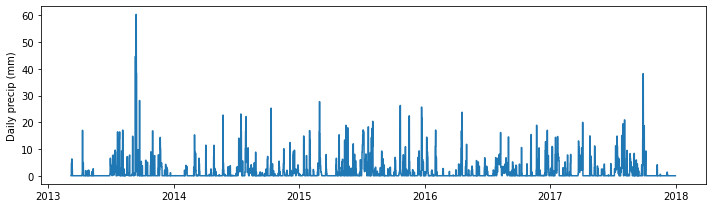

In [4]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

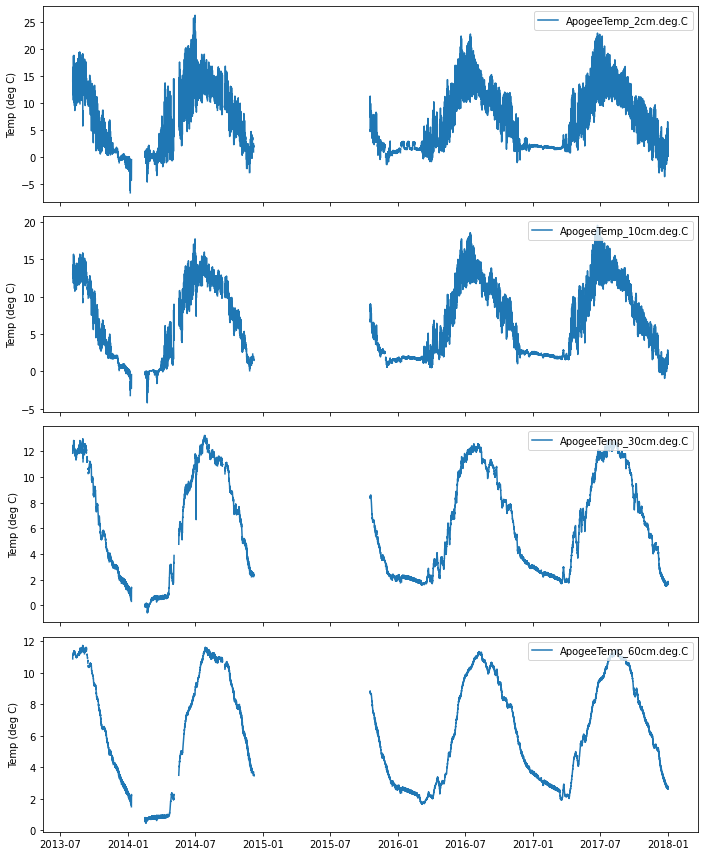

In [5]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

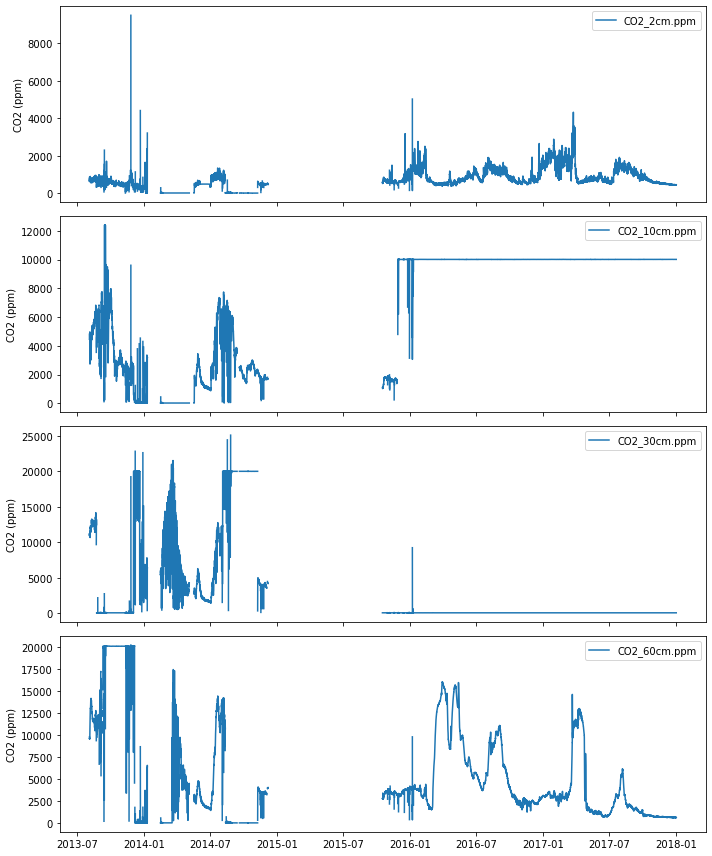

In [6]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

In [7]:
df['CO2_10cm.ppm']=df['CO2_10cm.ppm'].loc[:'2015-01-01']
df['CO2_30cm.ppm']=df['CO2_30cm.ppm'].loc[:'2015-01-01']

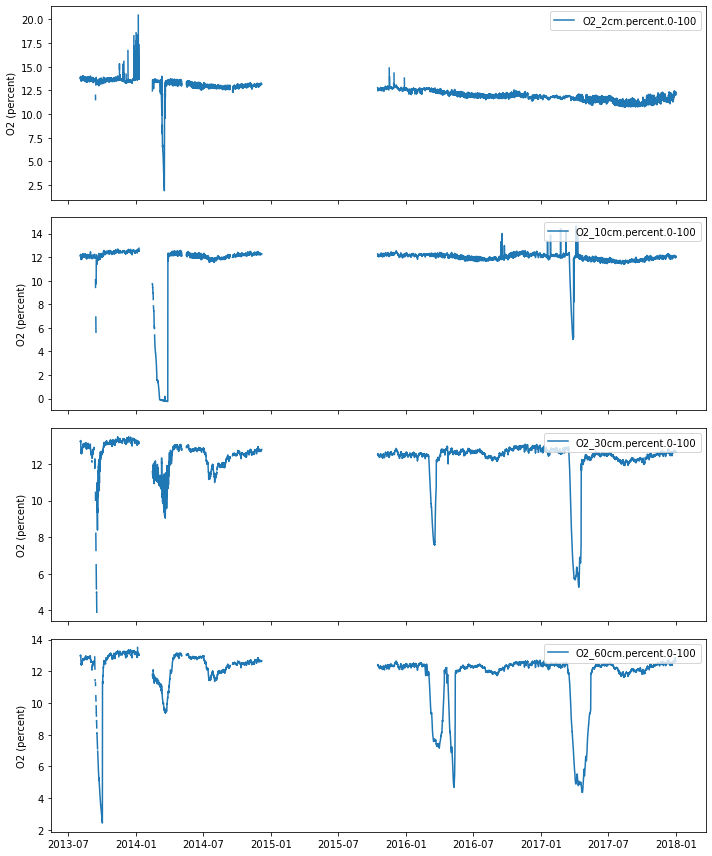

In [8]:
# Plot O2 data
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

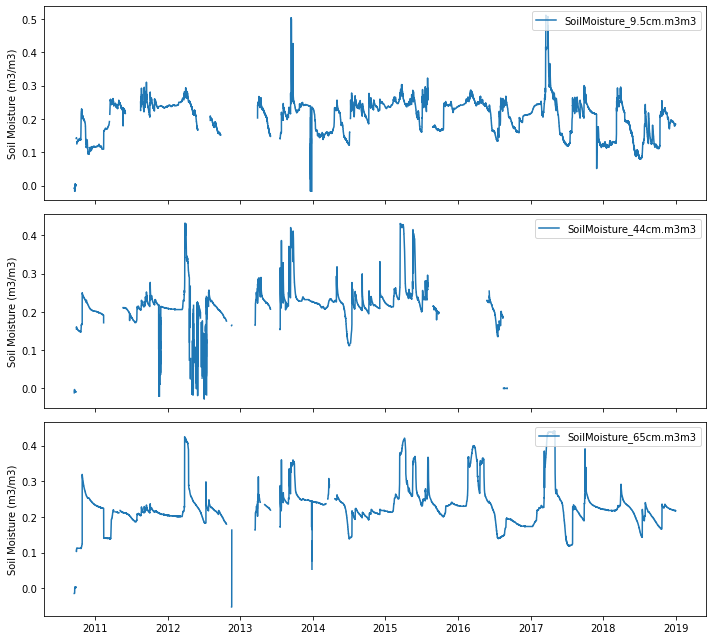

In [9]:
# Plot soil moisture data
# Is 65 close enough to 60 to keep?
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

In [10]:
df=df.drop(columns='SoilMoisture_44cm.m3m3')

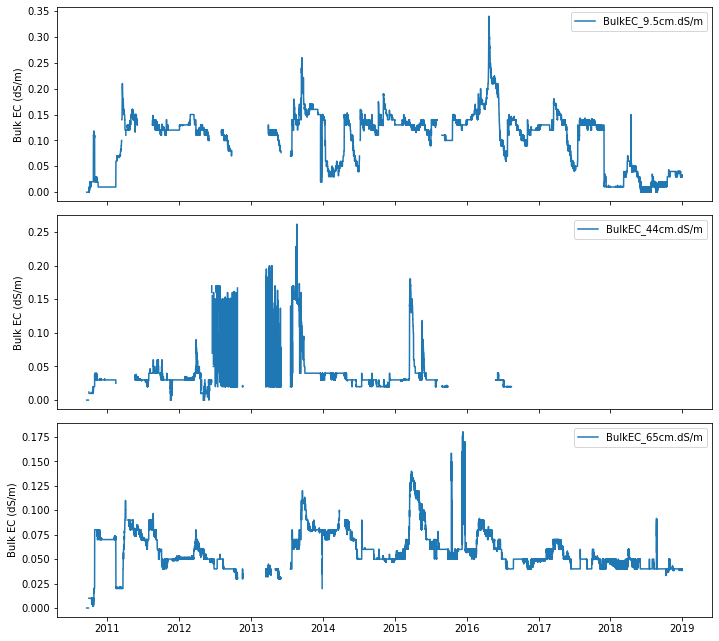

In [11]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

In [12]:
df=df.drop(columns='BulkEC_44cm.dS/m')

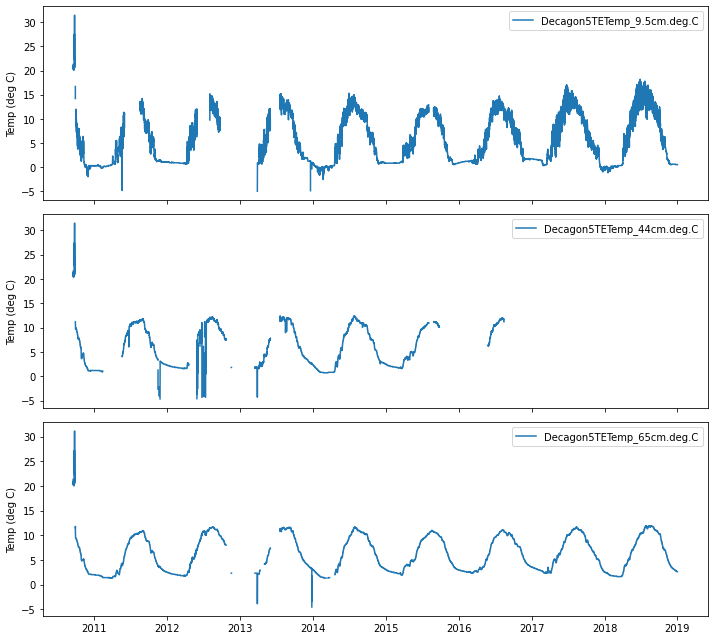

In [13]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [14]:
df=df.drop(columns='Decagon5TETemp_44cm.deg.C')
df=df.drop(columns='Voltage_11cm.mV')
df=df.drop(columns='Voltage_44cm.mV')

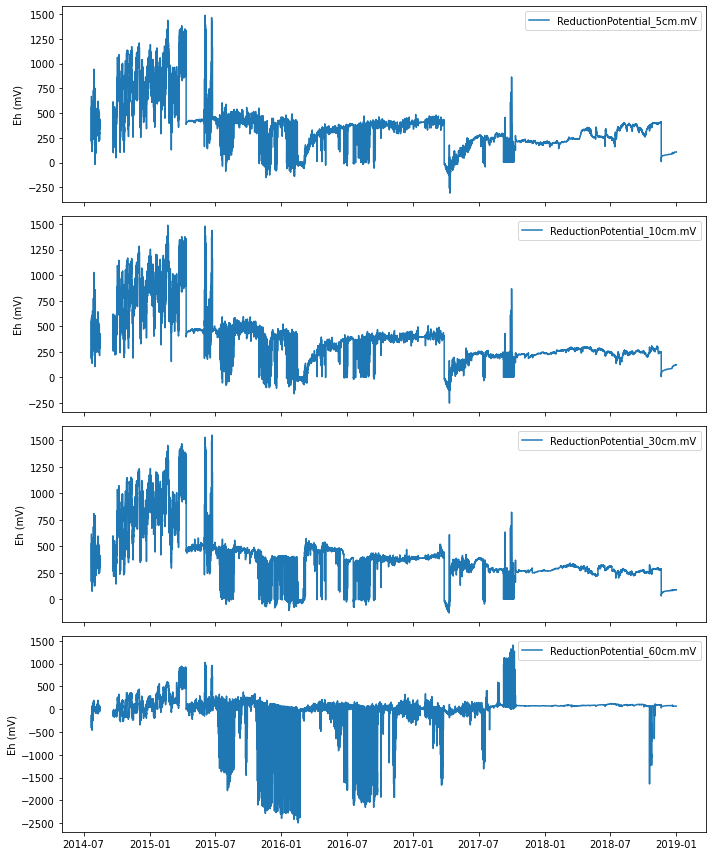

In [15]:
# Plot redox potential
eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [16]:
#Is 5cm close enough to 2 cm to keep?
#df=df.drop(columns='ReductionPotential_5cm.mV')

In [17]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/MC_Pit2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [18]:
output

,SoilMoisture_9.5cm.m3m3,Decagon5TETemp_9.5cm.deg.C,BulkEC_9.5cm.dS/m,SoilMoisture_65cm.m3m3,Decagon5TETemp_65cm.deg.C,BulkEC_65cm.dS/m,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,...,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,CO2_30cm.ppm,CO2_60cm.ppm,ReductionPotential_5cm.mV,ReductionPotential_10cm.mV,ReductionPotential_30cm.mV,ReductionPotential_60cm.mV,PRISM_precip.mm
2010-09-17 15:00:00,-0.008000,21.250000,0.00,-0.015000,21.300000,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17 16:00:00,-0.008000,20.750000,0.00,-0.015000,20.716667,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17 17:00:00,-0.008000,20.566667,0.00,-0.015000,20.533333,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17 18:00:00,-0.008000,20.500000,0.00,-0.015000,20.500000,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17 19:00:00,-0.008000,20.500000,0.00,-0.015000,20.483333,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.184000,0.500000,0.03,0.217167,2.600000,0.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,107.700,125.500,91.300,67.3700,NaN
2018-12-31 20:00:00,0.183167,0.500000,0.03,0.217000,2.600000,0.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,107.700,125.700,91.300,67.3725,NaN
2018-12-31 21:00:00,0.184000,0.500000,0.03,0.217667,2.600000,0.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,107.700,125.700,91.300,67.3700,NaN
2018-12-31 22:00:00,0.183667,0.500000,0.03,0.217167,2.600000,0.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,107.700,125.425,91.300,67.3700,NaN
